## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive

drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  sample_data/


In [3]:
%cd drive/MyDrive/vdjdb

/content/drive/MyDrive/vdjdb


# **Example 2: Train & Test Datasets**
#### Train classifier on a train dataset, then test on another, independent test dataset.
The datasets used were downloaded from https://github.com/IdoSpringer/ERGO-II/tree/master/Samples. These are pickle files (vdjdb_no10x_train_samples.pickle, vdjdb_no10x_test_samples.pickle), whcih can be converted into a pandas dataframes and csv files easily. For example:
```python
def load_from_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

df_train = load_from_pickle("vdjdb_no10x_train_samples.pickle")
df_train = pd.DataFrame.from_dict(df_train)
df_train.to_csv("vdjdb_no10x_train_samples.csv", index = False)
```

### Parameters

Set manually

In [4]:
# set params
k_neighbours = 5
organism = 'human' # 'mouse' or 'human'
chains = ['alpha', 'beta'] # ['alpha', 'beta'] or ['alpha'] or ['beta']
cdrs = 'all' # 'cdr3' or 'all'

validate user-inputs

In [5]:
# make sure input config params are valid
assert organism=='mouse' or organism=='human'
assert cdrs=='all' or cdrs=='cdr3'
assert chains==['alpha', 'beta'] or chains==['beta', 'alpha'] or chains==['alpha'] or chains==['beta']

In [6]:
# get col names to consider for dropping duplicate TCRs
drop_dup_cols = ['epitope']

# add alpha chain col names
if 'alpha' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_a_aa']
elif 'alpha' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']

# add beta chain col names
if 'beta' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_b_aa']
elif 'beta' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']

## Train

### Prepare training data

In [7]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2 -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.0/478.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [8]:
import os
from tcrdist.repertoire import TCRrep
import matplotlib.pyplot as plt

In [10]:

df = pd.read_csv("paired.csv")
print('paired.columns:', list(df.columns))
df.head()

paired.columns: ['complex.id', 'cdr3_a_aa', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'v_a_gene', 'j_a_gene', 'mhc.a', 'mhc.b', 'antigen.species', 'antigen.epitope']


,complex.id,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,mhc.a,mhc.b,antigen.species,antigen.epitope
0,1,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,HIV-1,FLKEKGGL
1,2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,HLA-B*08,B2M,HIV-1,FLKEKGGL
2,3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV2*01,missing,HLA-B*08,B2M,HIV-1,FLKEKGGL
3,4,CAYRPPGTYKYIF,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,TRAV38-2/DV8*01,TRAJ40*01,HLA-B*08,B2M,HIV-1,FLKEKGGL
4,5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,HIV-1,FLKEQGGL


In [11]:
drop_dup_cols = ['antigen.epitope', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene']
df = df.drop_duplicates(subset=drop_dup_cols, keep='first').copy()
df.reset_index(drop=True, inplace=True)

# print(f'Dropped {n_orig - df_train.shape[0]} duplicate TCRs by columns {drop_dup_cols}.')
print(f'The new amount of TCRs per epitope:\n')
df['antigen.epitope'].value_counts()

The new amount of TCRs per epitope:



KLGGALQAK     13945
GILGFVFTL      1943
AVFDRKSDAK     1757
RAKFKQLL       1221
IVTDFSVIK       718
              ...  
NMLRIMASL         1
KLIEYTDFA         1
MVWGPDPLYV        1
RQFGPDFPTI        1
SSGDATTAY         1
Name: antigen.epitope, Length: 913, dtype: int64

In [12]:
# df.head()

In [13]:
def print_num_epitopes(df , threshold):

    freq_count = df["antigen.epitope"].value_counts()

    print(f"""Epitopes having less than {threshold} datapoints:  {freq_count[freq_count<threshold].shape[0]}""")

    print(f"""Epitopes having more than {threshold} datapoints:  {df["antigen.epitope"].nunique() - freq_count[freq_count<threshold].shape[0]}""")

print_num_epitopes(df, 350)

Epitopes having less than 350 datapoints:  900
Epitopes having more than 350 datapoints:  13


In [14]:


def filter_data(N, df):

    freq_count = df["antigen.epitope"].value_counts()
    antigen_epitopes = []
    for antigen_epitope in freq_count[freq_count>N].index:
      antigen_epitope_df = df[df["antigen.epitope"] == antigen_epitope][:N]

      antigen_epitopes.append(antigen_epitope_df)

    df = pd.concat(antigen_epitopes)
    return df


df = filter_data(350, df)
df["antigen.epitope"].value_counts()

KLGGALQAK         350
GILGFVFTL         350
AVFDRKSDAK        350
RAKFKQLL          350
IVTDFSVIK         350
YLQPRTFLL         350
RLRAEAQVK         350
NLVPMVATV         350
TFEYVSQPFLMDLE    350
ELAGIGILTV        350
TTDPSFLGRY        350
SPRWYFYYL         350
GLCTLVAML         350
Name: antigen.epitope, dtype: int64

In [15]:
df

,complex.id,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,mhc.a,mhc.b,antigen.species,antigen.epitope
2439,2819,CADLGSQGNLIF,CASSEGWHSYEQYF,TRBV6-1*01,TRBJ2-7*01,TRAV5*01,TRAJ42*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
2440,2820,CALSDPGYSSASKIIF,CASGLNIDGDEQFF,TRBV12-5*01,TRBJ2-1*01,TRAV19*01,TRAJ3*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
2443,2823,CAVGNRDDKIIF,CASSVMLDSPLHF,TRBV9*01,TRBJ1-6*01,TRAV22*01,TRAJ30*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
2445,2825,CAYRSSPWGTNAGKSTF,CASSFTYRDTQYF,TRBV28*01,TRBJ2-3*01,TRAV38-2/DV8*01,TRAJ27*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
2447,2827,CATDRDDKIIF,CASSVRSSMNTEAFF,TRBV9*01,TRBJ1-1*01,TRAV17*01,TRAJ30*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
...,...,...,...,...,...,...,...,...,...,...,...
24901,27788,CAEDNNARLMF,CSARDRGIGNTIYF,TRBV20-1*01,TRBJ1-3*01,TRAV5*01,TRAJ31*01,HLA-A*02:01,B2M,EBV,GLCTLVAML
24902,27789,CAEVTDKLIF,CASSVVGNEQFF,TRBV9*01,TRBJ2-1*01,TRAV5*01,TRAJ34*01,HLA-A*02:01,B2M,EBV,GLCTLVAML
24903,27790,CLVGGSYNTNAGKSTF,CASSPEDYEQYF,TRBV18*01,TRBJ2-7*01,TRAV4*01,TRAJ27*01,HLA-A*02:01,B2M,EBV,GLCTLVAML
24904,27791,CVVNGMDSSYKLIF,CASSEGRVLPGELFF,TRBV2*01,TRBJ2-2*01,TRAV12-1*01,TRAJ12*01,HLA-A*02:01,B2M,EBV,GLCTLVAML


In [16]:
df_train_list, df_test_list = [], []
N = 350
n_train, n_test = int(N*0.80),  int(N*0.20)
# n_train, n_test = 3640, 910

for antigen_epitope in df["antigen.epitope"].unique():
    train = df[df["antigen.epitope"] == antigen_epitope][:n_train]
    test = df[df["antigen.epitope"] == antigen_epitope][n_train:]

    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print("df_train.shape: ",df_train.shape[0])
print("df_test.shape: ",df_test.shape[0])

df_train.shape:  3640
df_test.shape:  910


Drop duplicate TCRs for each epitope *separately*

In [17]:
n_orig = df_train.shape[0]
print(f'The dataset contains {df_train.shape[0]} TCRs for {len(df_train["antigen.epitope"].unique())} different epitopes\n')

The dataset contains 3640 TCRs for 13 different epitopes



### Get tcrdist distances for training data

*If asked to use all cdrs to compute tcrdist distances, can compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [22]:
from tcrdist.repertoire import TCRrep
df_train = df_train.sample(frac = 1) # shuffle


tr = TCRrep(cell_df=df_train,
            chains = chains,
            organism=organism,
            deduplicate=True) # This step will remove any TCRs where we could not infer genes

# <X> will be our matrix of distances, which will depend on <chains> and <cdrs>
X = None
if cdrs=='all':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_beta)
if cdrs=='cdr3':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)

assert X is not None

In [23]:
Y = pd.DataFrame(tr.clone_df['antigen.epitope']) # training data labels

In [24]:
# Make sure X and Y are valid
assert X.shape[0] == X.shape[1], f'assert X shape is nXn: {X.shape[0]} == {X.shape[1]} ?'
#assert X.shape[0] == df_train.shape[0], f'assert X dimension equals df_train dimension: {X.shape[0]} == {df_train.shape[0]} ?'
assert X.shape[0] == Y.shape[0],  f'assert Y length = n: {X.shape[0]} == {Y.shape[0]} ?'

X.index = list(X.index) # change from range to int
Y.index = list(Y.index) # change from range to int
assert (X.index.equals(Y.index)), f'assert X and Y indices are equal'

### Train KNN model

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from matplotlib.patches import Rectangle

In [26]:
# train model on entire train set
model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance')
model.fit(X, Y.values.ravel())

KNeighborsClassifier(metric='precomputed', weights='distance')

## Test

### Prepare test data

Keep only TCRs that have CDR3a and CDR3b, specific to epitope presented on MHC class 1, specifically HLA-A*02

In [27]:
df_test.head()

,complex.id,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,mhc.a,mhc.b,antigen.species,antigen.epitope
3155,3548,CAVHGYGQNFVF,CASSEGDSNYEQYF,TRBV9*01,TRBJ2-7*01,TRAV21*01,TRAJ26*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
3157,3550,CAGVYSSASKIIF,CASSDYGLAGEQFF,TRBV6-4*01,TRBJ2-1*01,TRAV1-2*01,TRAJ3*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
3159,3552,CAVLRMDSSYKLIF,CASSEASGGANIQYF,TRBV6-6*01,TRBJ2-4*01,TRAV21*01,TRAJ12*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
3160,3553,CAVNMYGDSSYKLIF,CASSSTDTQYF,TRBV5-6*01,TRBJ2-3*01,TRAV12-2*01,TRAJ12*01,HLA-A*03:01,B2M,CMV,KLGGALQAK
3162,3555,CLVGDSWGKLQF,CSAPGLADSYEQYF,TRBV20-1*01,TRBJ2-7*01,TRAV4*01,TRAJ24*01,HLA-A*03:01,B2M,CMV,KLGGALQAK


Keep only epitopes included in the train set

In [28]:
peptide_list = list(df_train['antigen.epitope'].unique())
df_test = df_test.loc[df_test['antigen.epitope'].isin(peptide_list)]
df_test.reset_index(drop=True, inplace=True)

### Get tcrdist distances between test TCRs and train TCRs
*If asked to use all cdrs to compute tcrdist distances, compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [29]:
tcrrep_test = TCRrep(cell_df=df_test,
                     organism=organism,
                     chains=chains,
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

Get distances matrix (X_test) between test and train TCRs

In [30]:
if cdrs=='all':
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha + tcrrep_test.rw_beta)
  elif chains==['alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha)
  elif chains==['beta']:
      X_test = pd.DataFrame(tcrrep_test.rw_beta)

if cdrs == "cdr3":
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa + tcrrep_test.rw_cdr3_b_aa)
  elif chains==['alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa)
  elif chains==['beta']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_b_aa)

In [31]:
# assert dimensions are n_test X n_train
#assert X_test.shape[0] == df_test.shape[0], f'assert X_test rows dimension equals df_test dimension: {X_test.shape[0]} == {df_test.shape[0]} ?'
assert X_test.shape[1] == X.shape[0], f'assert X columns dimension equals X(train) dimension: {X.shape[0]} == {df_train.shape[0]} ?'

In [32]:
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)

# get test data labels
Y_test = tcrrep_test.clone_df['antigen.epitope']

In [33]:
Y_test

0           NLVPMVATV
1           NLVPMVATV
2           NLVPMVATV
3           NLVPMVATV
4           NLVPMVATV
            ...      
904    TFEYVSQPFLMDLE
905    TFEYVSQPFLMDLE
906    TFEYVSQPFLMDLE
907    TFEYVSQPFLMDLE
908    TFEYVSQPFLMDLE
Name: antigen.epitope, Length: 909, dtype: object

### Plot results

Calculate performance metrics

In [34]:
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [35]:
metrics_df.T

,precision,recall,f1
AVFDRKSDAK,0.125000,0.085714,0.101695
ELAGIGILTV,0.561798,0.714286,0.628931
GILGFVFTL,0.595745,0.811594,0.687117
GLCTLVAML,0.568182,0.714286,0.632911
IVTDFSVIK,0.343750,0.314286,0.328358
KLGGALQAK,0.175000,0.100000,0.127273
NLVPMVATV,0.476190,0.428571,0.451128
RAKFKQLL,0.442308,0.657143,0.528736
RLRAEAQVK,0.131579,0.071429,0.092593
SPRWYFYYL,0.520000,0.371429,0.433333


Plot confusion matrix

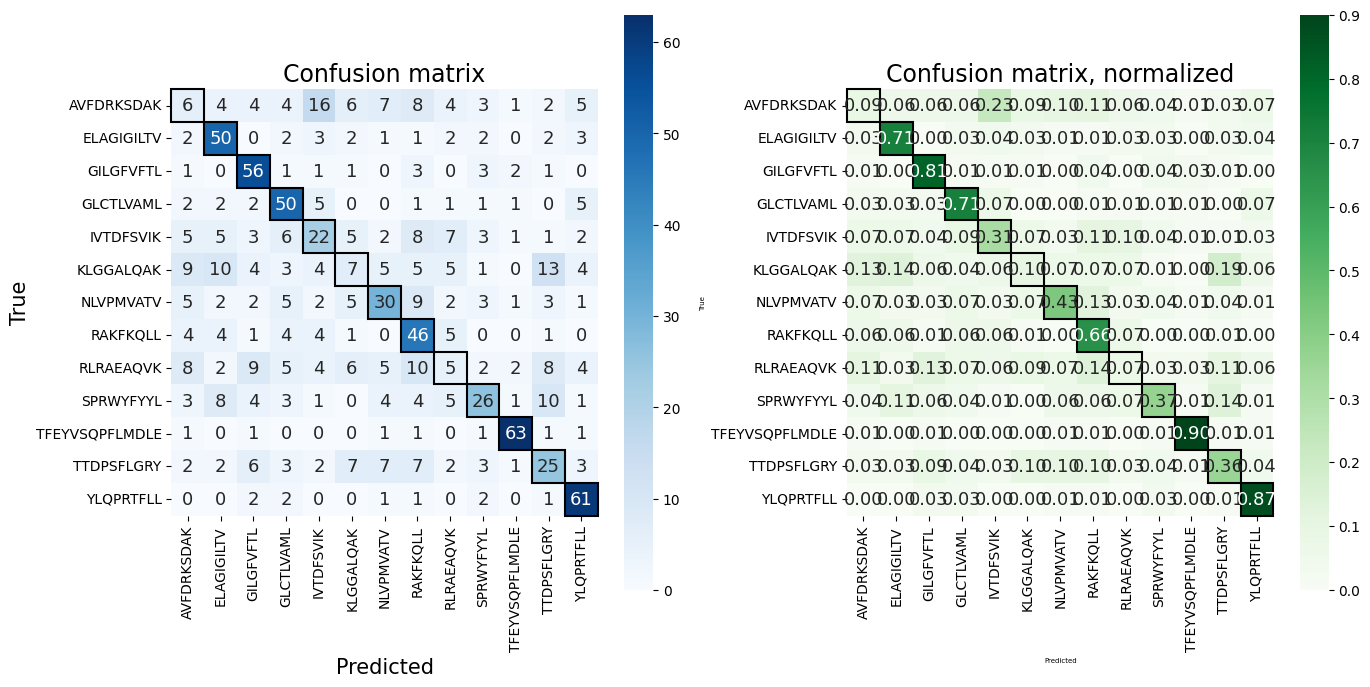

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=5)
axes[1].set_ylabel('True', fontsize=5)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

Plot metrics (per epitope)

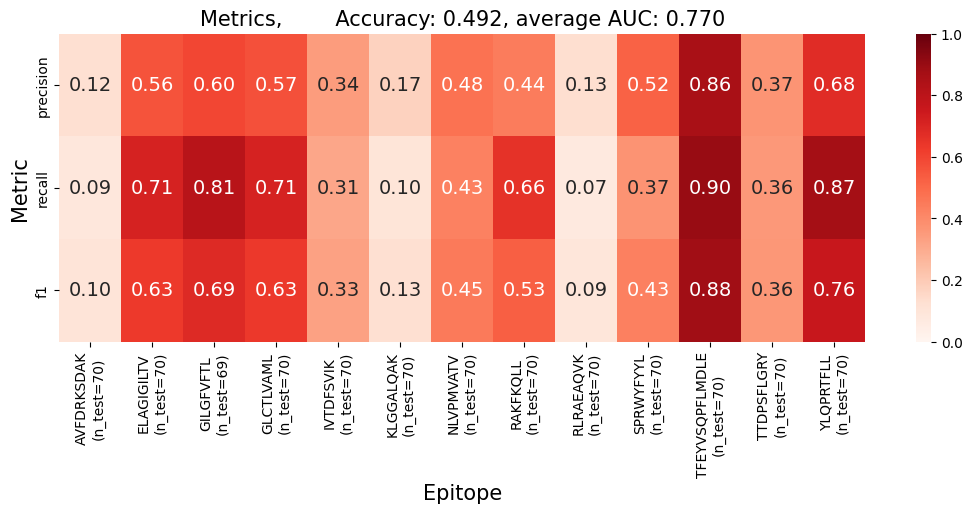

In [37]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])


Plot ROC curves

In [38]:
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['antigen.epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]

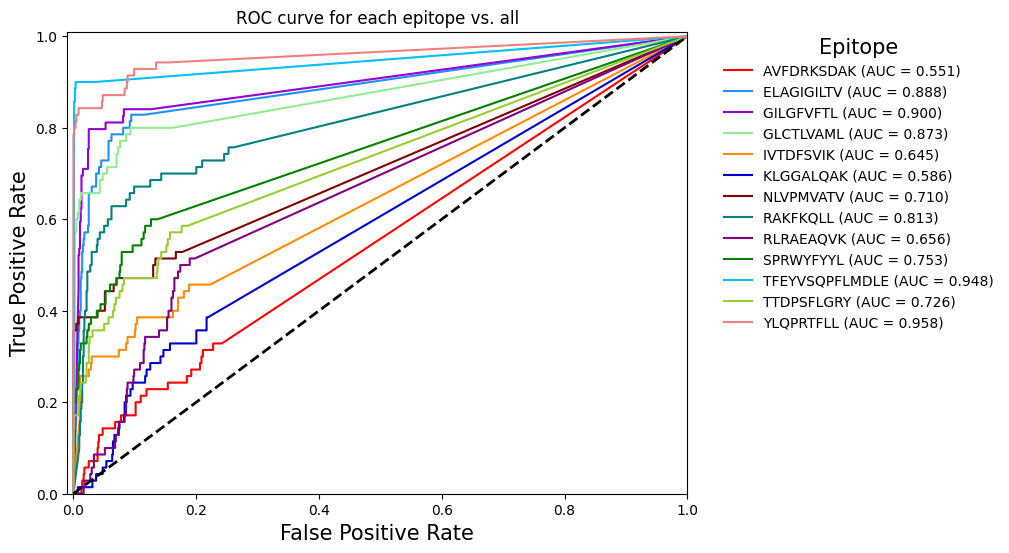

In [39]:
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)

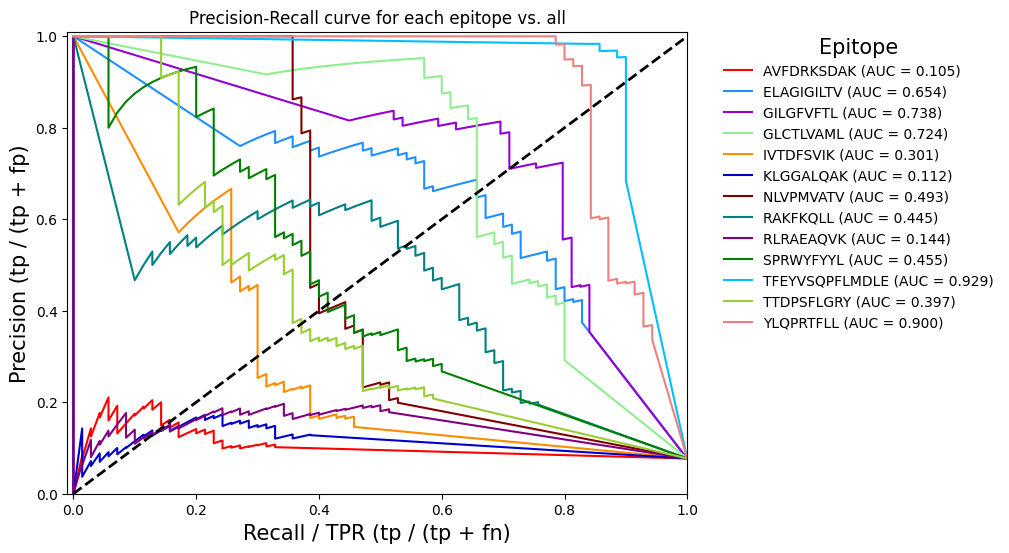

In [40]:
from sklearn.metrics import precision_recall_curve

# Get precision_recall curve info for each epitope
precision_cur = dict()
recall_cur = dict()
pre_rec_auc = dict()
for i, ep in enumerate(model.classes_):
    precision_cur[ep], recall_cur[ep], _ = precision_recall_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    pre_rec_auc[ep] = auc(recall_cur[ep], precision_cur[ep])

# Plot precision_recall curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(recall_cur[ep], precision_cur[ep], color=color, lw=1.5, label=f'{ep} (AUC = {pre_rec_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall / TPR (tp / (tp + fn)', fontsize=15)
plt.ylabel('Precision (tp / (tp + fp)', fontsize=15)
plt.title('Precision-Recall curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)